# **Test from User trained Fast RCNN model**

## Load required libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
import torch.nn as nn
import os
from torchvision import transforms, models

import random
import cv2

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Custom Data Load

In [3]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

In [4]:
import albumentations as A
from torchvision.transforms import v2

torch.cuda.empty_cache()

BS=16
LR=0.00005
epochs=20
IS=256
D='cuda' if torch.cuda.is_available() else 'cpu'


augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

class FractureData(torch.utils.data.Dataset):

    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])

        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape

        file=open(tp,'r')
        target=list(map(float,file.read().split()))

        try:
            label=[target.pop(0)]
            bbox=[]
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)

            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)

        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()

        annot={'boxes':bbox,'labels':label}

        return image, annot

    def collate_fn(self,batch):
        return tuple(zip(*batch))

## Give Test Dataset Paths

In [5]:
test_dir_path='/content/drive/MyDrive/Bone Fracture Detection/Data/test'
test_img_paths = sorted(os.listdir('/content/drive/MyDrive/Bone Fracture Detection/Data/test/images'))
test_target_paths = sorted(os.listdir('/content/drive/MyDrive/Bone Fracture Detection/Data/test/labels'))

testset=FractureData(test_dir_path, test_img_paths, test_target_paths, augs)

In [6]:
#check
testset[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[ 47,  45, 169, 114],
          [ 76,  49, 202, 157]]),
  'labels': tensor([4, 4])})

## Classes

In [7]:
num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}

## Transfer Learning

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):

    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [9]:
model = create_model(num_classes=num_classes)
checkpoint = torch.load('/content/drive/MyDrive/Bone Fracture Detection/Fast RCNN/Models/FullyTrainedModel.pt', map_location=D)
model.load_state_dict(checkpoint)
model.to(D).eval()

# define the detection threshold...
# ... any detection having score below this will be discarded
# detection_threshold = 0.8

# # to count the total number of images iterated through
# frame_count = 0

# # to keep adding the FPS for each image
# total_fps = 0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 69.8MB/s]


## Test Output

### For a random Image

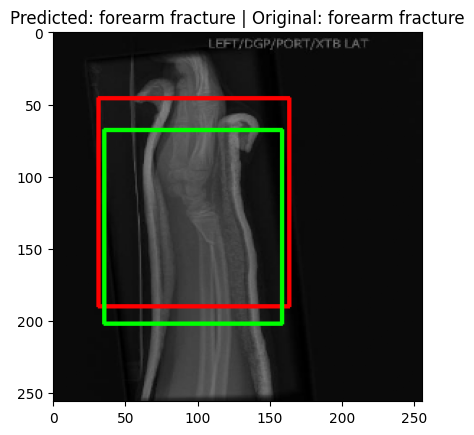

In [34]:
idx=random.randint(0,len(testset)-1)
# print(idx)
test_img,test_tar=testset[idx]
# print(test_tar) #type-dict

model.eval()

pred=model(test_img.unsqueeze(0).to(D))
# print(pred) #type-list

# pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
pred_label=pred[0]['labels'][0].item()
orig_label=test_tar['labels'][0].item()

Txmin,Tymin,Txmax,Tymax=test_tar['boxes'][0].tolist()

#predicted rectangle
image=cv2.rectangle(test_img.permute(1,2,0).numpy(),(xmin,ymin),(xmax,ymax),(255,0,0),2)

#original rectangle
image=cv2.rectangle(image,(Txmin,Tymin),(Txmax,Tymax),(0,255,0),2)

plt.imshow(image)
plt.title("Predicted: " + str(l2c[pred_label]) + " | Original: " +str(l2c[orig_label]))
plt.show()

### Iterate through all images

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for i in range(len(testset)):
  test_img,test_tar=testset[i]
  model.eval()
  pred=model(test_img.unsqueeze(0).to(D))
  # pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
  # xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
  out=pred[0]['labels'][0].item()
  y_pred.append(out)
  org=test_tar['labels'][0].item()
  y_true.append(org)


<ipython-input-38-946e825ff1b2>:2: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],


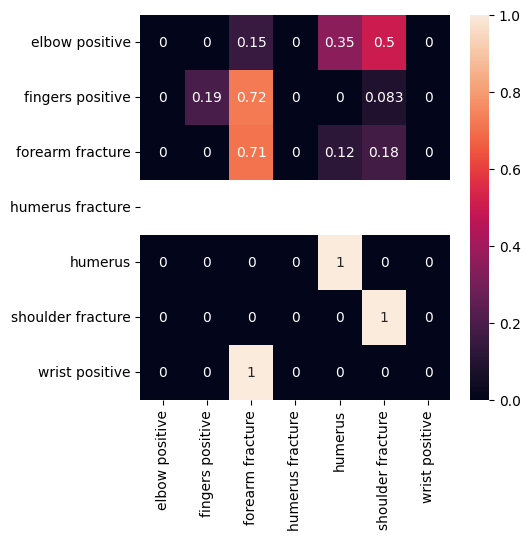

In [38]:
cf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [29]:
#check
yt = set(y_true)
print(yt)

{0, 1, 2, 4, 5, 6}


In [30]:
#check
yp = set(y_pred)
print(yp)

{1, 2, 4, 5}


In [28]:
#check
print(y_pred)
print(y_true)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 1, 1, 1, 1, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 2, 2, 2, 2, 4, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 5, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4,